# Module 03 — Housing Price Predictions
## CSE 450 Machine Learning | Team 8

**Team**: Dawson, Peter, Tanner
**Objective**: Predict King County house prices using regression models

### Tasks Covered

| Task | Stakeholder | Section |
|------|-------------|---------|
| **Core Task** | All | Build and tune regression model |
| **Task 1** | Cecil (VP Customer Relations) | Prediction reliability evidence |
| **Task 2** | Cecil (VP Customer Relations) | Holdout CSV predictions |
| **Task 3** | William (VP Finance) | Feature importance analysis |
| **Task 4** | Devon (CEO) | External factors investigation |
| **Task 5 / Q4** | Johnny (Intern) | Feature scaling explanation |
| **Task 6 / Q3** | William (VP Finance) | Insurance & ethics |
| **Task 7 / Q1** | Devon (CEO) | ML problem type |

---

In [34]:
# Install required packages (Google Colab only — skipped on local machines)
import sys
if 'google.colab' in sys.modules:
    !pip install -q xgboost

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print('All imports loaded successfully.')

All imports loaded successfully.


## 1. Load Data

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

print(f'Training:     {df.shape[0]:,} rows x {df.shape[1]} cols')
print(f'Holdout:      {holdout.shape[0]:,} rows x {holdout.shape[1]} cols')
print(f'Mini holdout: {mini_holdout.shape[0]:,} rows x {mini_holdout.shape[1]} cols')
print(f'\nTraining columns: {list(df.columns)}')
print(f'Holdout columns:  {list(holdout.columns)}')

Training:     20,000 rows x 21 cols
Holdout:      1,613 rows x 20 cols
Mini holdout: 81 rows x 20 cols

Training columns: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']
Holdout columns:  ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


## 2. Data Exploration

In [37]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  str    
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_living15  20

In [38]:
df.describe().round(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.000000e+04,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,4.580297e+09,3.37,2.12,2079.88,15015.33,1.50,0.01,0.23,3.41,7.66,1790.23,289.65,1971.10,82.73,98077.88,47.56,-122.21,1986.39,12748.96,539436.71
std,2.875295e+09,0.93,0.77,919.43,39701.35,0.54,0.09,0.77,0.65,1.18,829.59,441.54,29.37,397.87,53.44,0.14,0.14,685.21,27076.49,366433.44
min,1.000102e+06,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,75000.00
25%,2.123049e+09,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.75,0.00,98033.00,47.47,-122.33,1490.00,5100.00,322000.00
50%,3.904955e+09,3.00,2.25,1910.00,7620.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7622.00,450000.00
75%,7.309825e+09,4.00,2.50,2550.00,10710.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98117.00,47.68,-122.12,2360.00,10088.25,641625.00
max,9.900000e+09,33.00,8.00,13540.00,1164794.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00,7700000.00


In [39]:
# Missing values
missing = df.isnull().sum()
print('Missing values:')
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print('None found — dataset is clean.')

Missing values:
None found — dataset is clean.


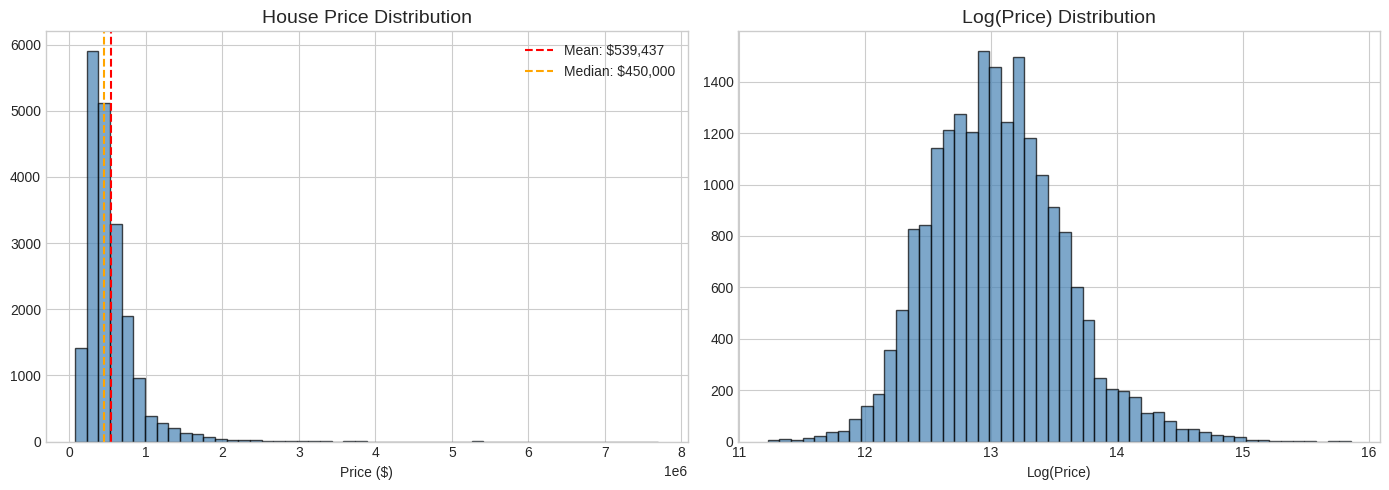

Price range: $75,000 to $7,700,000
Skewness: 4.09


In [40]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('House Price Distribution', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].axvline(df['price'].mean(), color='red', linestyle='--',
                label=f'Mean: ${df["price"].mean():,.0f}')
axes[0].axvline(df['price'].median(), color='orange', linestyle='--',
                label=f'Median: ${df["price"].median():,.0f}')
axes[0].legend()

axes[1].hist(np.log1p(df['price']), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Log(Price) Distribution', fontsize=14)
axes[1].set_xlabel('Log(Price)')

plt.tight_layout()
plt.show()
print(f'Price range: ${df["price"].min():,.0f} to ${df["price"].max():,.0f}')
print(f'Skewness: {df["price"].skew():.2f}')

In [41]:
# Correlations with price
corr = df.select_dtypes(include=[np.number]).corr()['price'].sort_values(ascending=False)
print('Correlation with price:')
print(corr.to_string())

Correlation with price:
price            1.000000
sqft_living      0.703920
grade            0.666447
sqft_above       0.607082
sqft_living15    0.585374
bathrooms        0.527989
view             0.395961
sqft_basement    0.325183
lat              0.307516
bedrooms         0.307281
waterfront       0.260133
floors           0.254428
yr_renovated     0.121534
sqft_lot         0.090317
sqft_lot15       0.082413
yr_built         0.054187
condition        0.035146
long             0.023976
id              -0.016081
zipcode         -0.055857


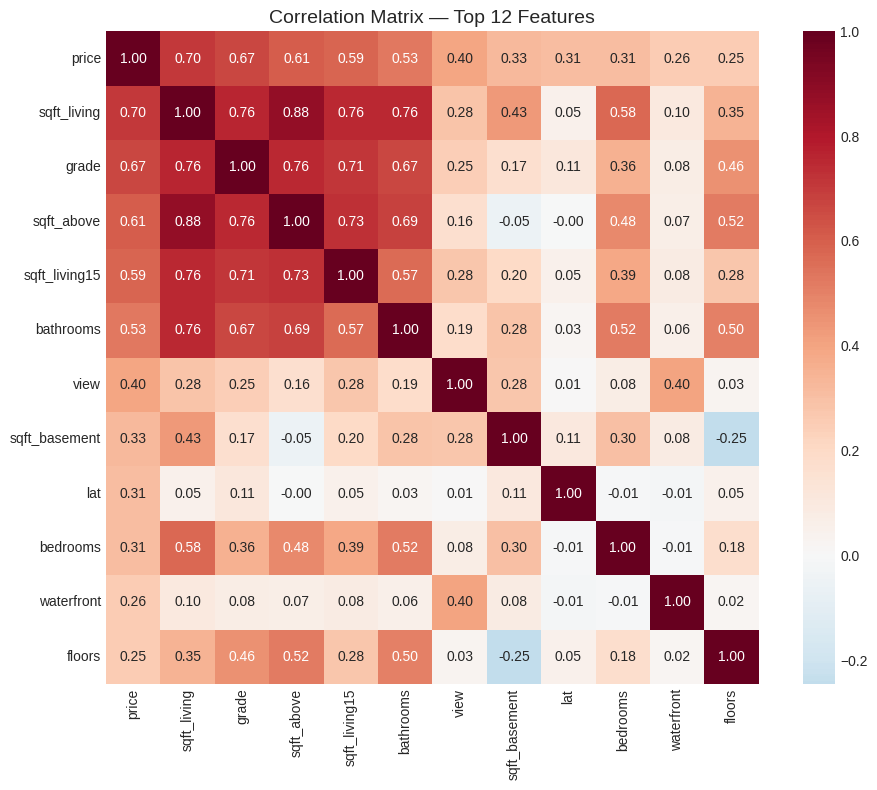

In [42]:
# Correlation heatmap — top features
top_feats = corr.abs().sort_values(ascending=False).head(12).index
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[top_feats].corr(), annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax, square=True)
ax.set_title('Correlation Matrix — Top 12 Features', fontsize=14)
plt.tight_layout()
plt.show()

### 2.1 Data Quality & Outlier Detection

Before engineering any features, we need to understand what's clean, what's noisy, and what's broken.

In [43]:
# Data quality issues
print("=== DATA QUALITY CHECK ===")
print(f"Total rows: {len(df):,}")
print(f"Duplicate IDs: {df['id'].duplicated().sum()} (houses sold multiple times)")
print()

# Outlier: 33 bedrooms
print("Bedroom outlier:")
print(df[df['bedrooms'] > 10][['bedrooms', 'bathrooms', 'sqft_living', 'price']].to_string())
print("-> 33 bedrooms with 1,620 sqft is clearly a data entry error (should be 3)")
print()

# Zero values
print("Edge cases:")
print(f"  Bedrooms = 0:  {(df['bedrooms'] == 0).sum()} rows")
print(f"  Bathrooms = 0: {(df['bathrooms'] == 0).sum()} rows")
print(f"  Grade = 1:     {(df['grade'] == 1).sum()} rows (extremely low)")
print(f"  Condition = 1: {(df['condition'] == 1).sum()} rows")
print()

# Renovation data
print(f"Renovated homes: {(df['yr_renovated'] > 0).sum()} ({(df['yr_renovated'] > 0).mean()*100:.1f}%)")
print(f"Waterfront:      {(df['waterfront'] == 1).sum()} ({(df['waterfront'] == 1).mean()*100:.1f}%)")

=== DATA QUALITY CHECK ===
Total rows: 20,000
Duplicate IDs: 154 (houses sold multiple times)

Bedroom outlier:
      bedrooms  bathrooms  sqft_living     price
743         11       3.00         3000  520000.0
6984        33       1.75         1620  640000.0
-> 33 bedrooms with 1,620 sqft is clearly a data entry error (should be 3)

Edge cases:
  Bedrooms = 0:  11 rows
  Bathrooms = 0: 8 rows
  Grade = 1:     1 rows (extremely low)
  Condition = 1: 29 rows

Renovated homes: 829 (4.1%)
Waterfront:      151 (0.8%)


### 2.2 Price by Key Features

Understanding which features drive price helps us decide what to engineer.

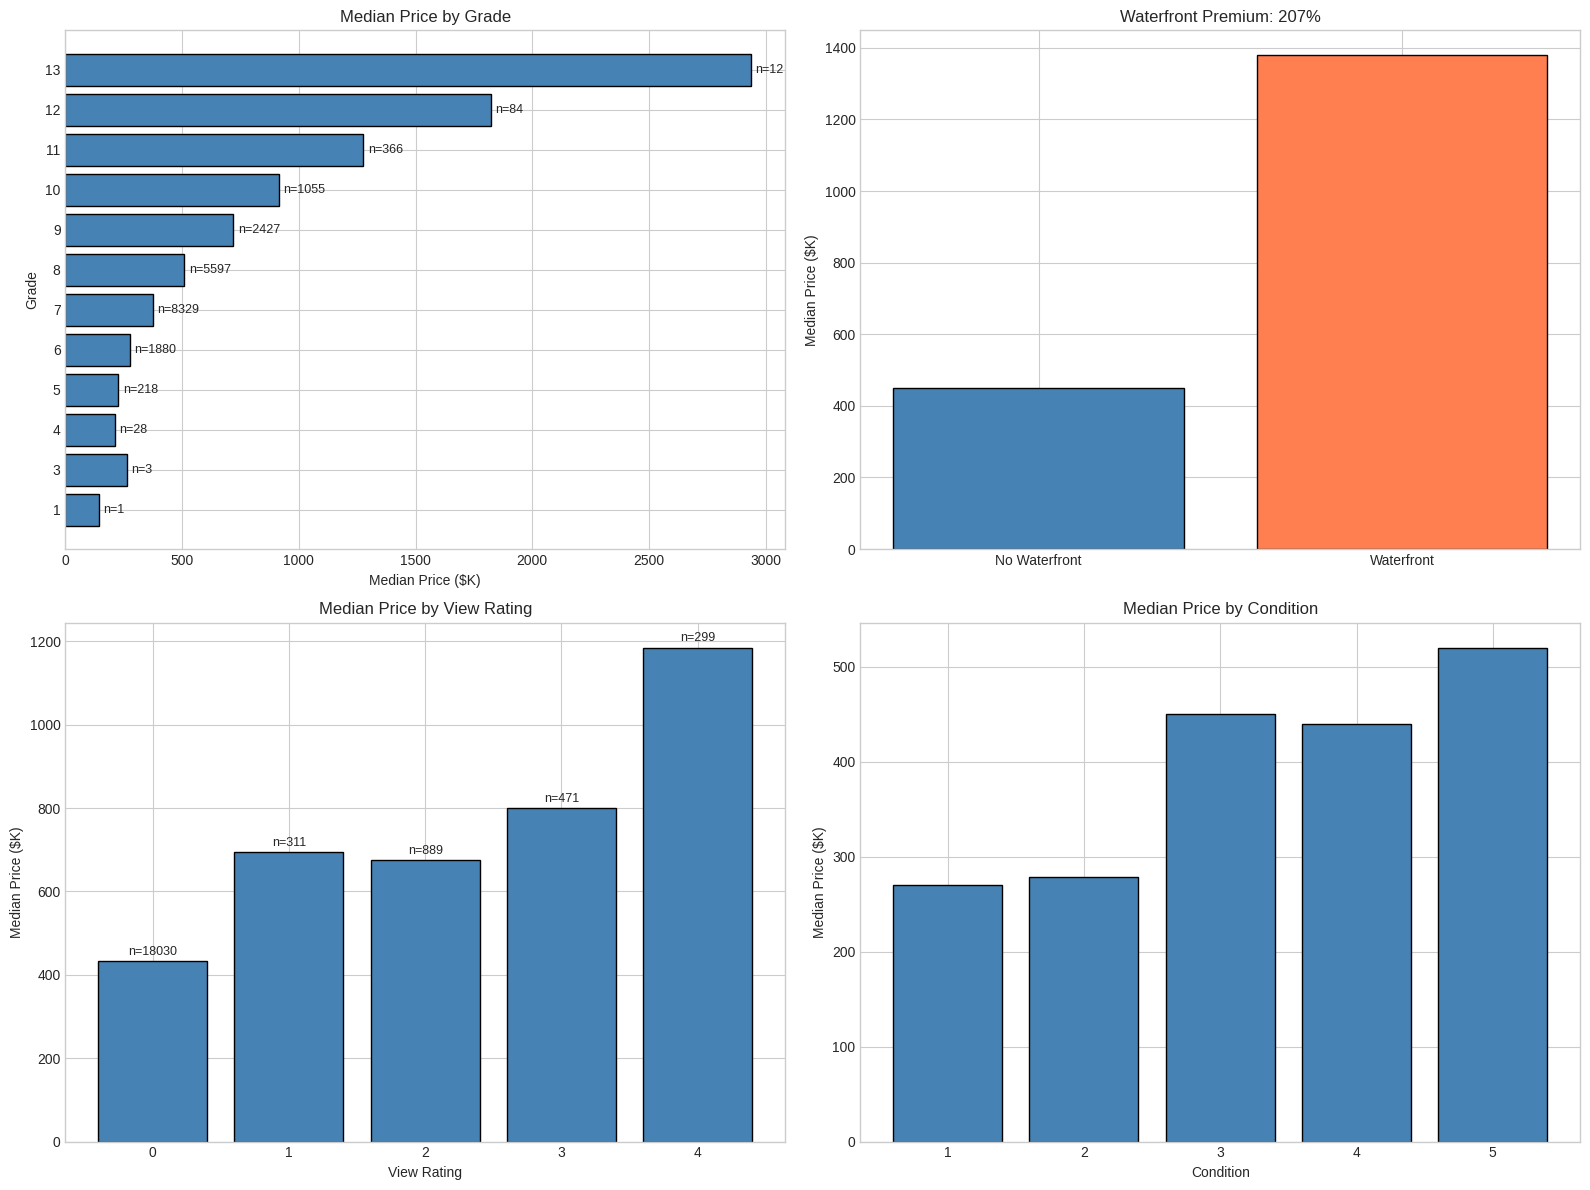

Key takeaway: Grade is the strongest categorical predictor.
Grade 5 median: $226,225
Grade 13 median: $2,935,500
-> 13x price difference across grades


In [44]:
# Price by grade — the dominant predictor
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grade vs Price
grade_stats = df.groupby('grade')['price'].agg(['median', 'count'])
axes[0, 0].barh(grade_stats.index.astype(str), grade_stats['median'] / 1000,
                color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Median Price ($K)')
axes[0, 0].set_ylabel('Grade')
axes[0, 0].set_title('Median Price by Grade')
for i, (idx, row) in enumerate(grade_stats.iterrows()):
    axes[0, 0].text(row['median']/1000 + 20, i, f"n={int(row['count'])}", va='center', fontsize=9)

# Waterfront vs Price
wf = df.groupby('waterfront')['price'].median()
axes[0, 1].bar(['No Waterfront', 'Waterfront'], wf.values / 1000,
               color=['steelblue', 'coral'], edgecolor='black')
axes[0, 1].set_ylabel('Median Price ($K)')
axes[0, 1].set_title(f'Waterfront Premium: {wf[1]/wf[0]-1:.0%}')

# View vs Price
view_stats = df.groupby('view')['price'].agg(['median', 'count'])
axes[1, 0].bar(view_stats.index.astype(str), view_stats['median'] / 1000,
               color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('View Rating')
axes[1, 0].set_ylabel('Median Price ($K)')
axes[1, 0].set_title('Median Price by View Rating')
for i, (idx, row) in enumerate(view_stats.iterrows()):
    axes[1, 0].text(i, row['median']/1000 + 15, f"n={int(row['count'])}", ha='center', fontsize=9)

# Condition vs Price
cond_stats = df.groupby('condition')['price'].agg(['median', 'count'])
axes[1, 1].bar(cond_stats.index.astype(str), cond_stats['median'] / 1000,
               color='steelblue', edgecolor='black')
axes[1, 1].set_xlabel('Condition')
axes[1, 1].set_ylabel('Median Price ($K)')
axes[1, 1].set_title('Median Price by Condition')

plt.tight_layout()
plt.show()

print("Key takeaway: Grade is the strongest categorical predictor.")
print(f"Grade 5 median: ${df[df['grade']==5]['price'].median():,.0f}")
print(f"Grade 13 median: ${df[df['grade']==13]['price'].median():,.0f}")
print(f"-> {df[df['grade']==13]['price'].median() / df[df['grade']==5]['price'].median():.0f}x price difference across grades")

### 2.3 Neighborhood Features — sqft_living15, sqft_lot15

`sqft_living15` and `sqft_lot15` represent the average size of the nearest 15 neighbors' homes and lots.
These are **neighborhood quality proxies** — if your neighbors have big homes, you're in a nice area.

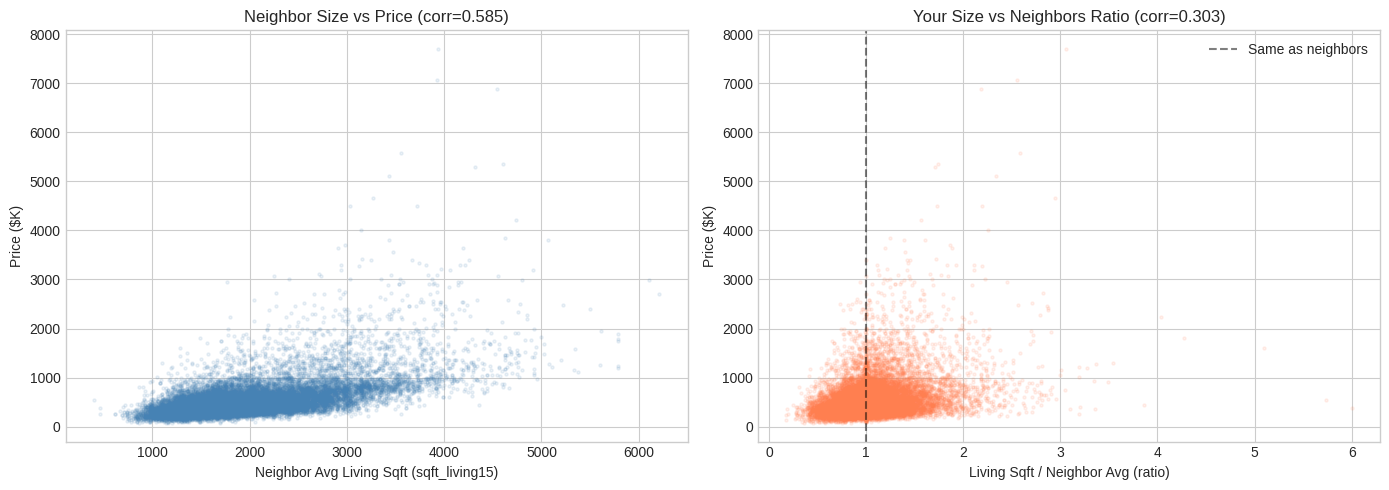

sqft_living15 correlation with price: 0.5854
sqft_lot15 correlation with price:    0.0824
living_vs_neighbors ratio corr:       0.3032

-> sqft_living15 is a strong price signal (neighborhood quality)
-> The ratio (your size vs neighbors) captures relative positioning


In [45]:
# How do neighbor features relate to price?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['sqft_living15'], df['price'] / 1000, alpha=0.1, s=5, color='steelblue')
axes[0].set_xlabel('Neighbor Avg Living Sqft (sqft_living15)')
axes[0].set_ylabel('Price ($K)')
axes[0].set_title(f'Neighbor Size vs Price (corr={df["sqft_living15"].corr(df["price"]):.3f})')

# Ratio: how does YOUR home compare to neighbors?
ratio = df['sqft_living'] / df['sqft_living15']
axes[1].scatter(ratio, df['price'] / 1000, alpha=0.1, s=5, color='coral')
axes[1].set_xlabel('Living Sqft / Neighbor Avg (ratio)')
axes[1].set_ylabel('Price ($K)')
axes[1].set_title(f'Your Size vs Neighbors Ratio (corr={ratio.corr(df["price"]):.3f})')
axes[1].axvline(1.0, color='black', linestyle='--', alpha=0.5, label='Same as neighbors')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"sqft_living15 correlation with price: {df['sqft_living15'].corr(df['price']):.4f}")
print(f"sqft_lot15 correlation with price:    {df['sqft_lot15'].corr(df['price']):.4f}")
print(f"living_vs_neighbors ratio corr:       {ratio.corr(df['price']):.4f}")
print()
print("-> sqft_living15 is a strong price signal (neighborhood quality)")
print("-> The ratio (your size vs neighbors) captures relative positioning")

### 2.4 Geographic Analysis

Location is everything in real estate. Let's see how geography maps to price.

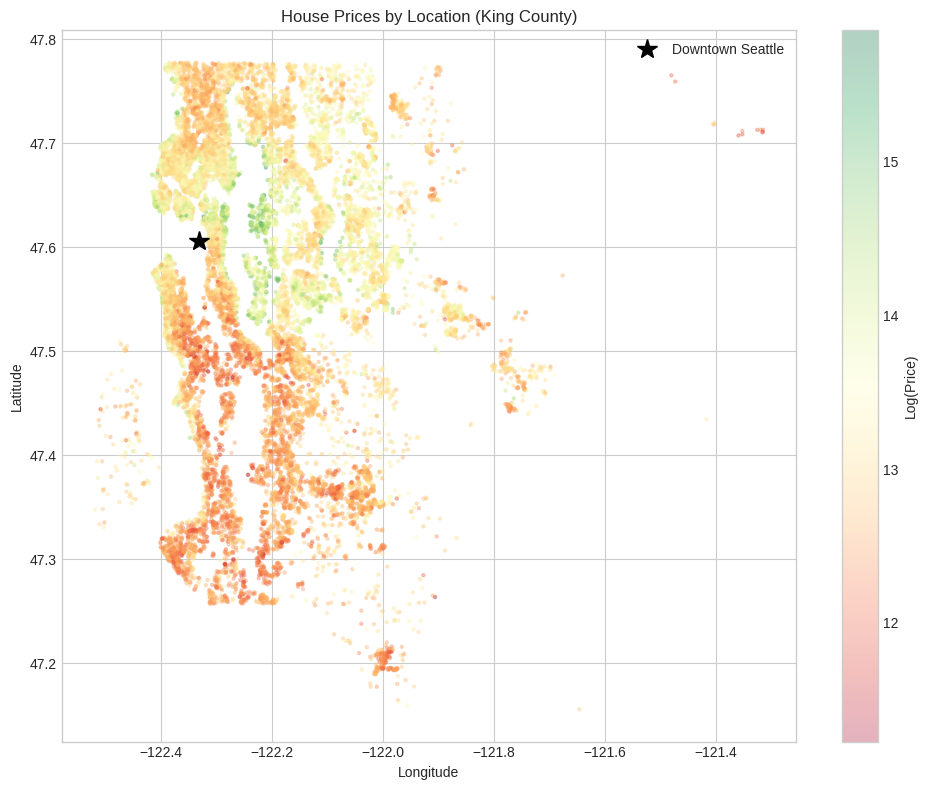

Distance to downtown Seattle correlation with price: -0.1900
-> Negative correlation means closer to Seattle = higher price

Cheapest zipcode median:    $235,000 (zip 98002)
Most expensive median:      $1,892,500 (zip 98039)
Price ratio (max/min):      8.1x
-> Zipcode captures massive price variation — 70 unique zipcodes


In [46]:
# Geographic price patterns
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(df['long'], df['lat'], c=np.log1p(df['price']),
                     cmap='RdYlGn', alpha=0.3, s=5)
plt.colorbar(scatter, label='Log(Price)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('House Prices by Location (King County)')

# Mark downtown Seattle
ax.plot(-122.3321, 47.6062, 'k*', markersize=15, label='Downtown Seattle')
ax.legend()

plt.tight_layout()
plt.show()

# Distance to Seattle correlation
dist = np.sqrt((df['lat'] - 47.6062)**2 + (df['long'] + 122.3321)**2)
print(f"Distance to downtown Seattle correlation with price: {dist.corr(df['price']):.4f}")
print(f"-> Negative correlation means closer to Seattle = higher price")
print()

# Zipcode price variation
zip_stats = df.groupby('zipcode')['price'].median().sort_values()
print(f"Cheapest zipcode median:    ${zip_stats.iloc[0]:,.0f} (zip {zip_stats.index[0]})")
print(f"Most expensive median:      ${zip_stats.iloc[-1]:,.0f} (zip {zip_stats.index[-1]})")
print(f"Price ratio (max/min):      {zip_stats.iloc[-1]/zip_stats.iloc[0]:.1f}x")
print(f"-> Zipcode captures massive price variation — {df['zipcode'].nunique()} unique zipcodes")

### 2.5 Feature Interactions & Skewness

Some features have multiplicative effects on price. Also checking which features need log-transformation.

In [47]:
# Grade x Size interaction
print("=== GRADE x SIZE INTERACTION ===")
df['_grade_high'] = (df['grade'] >= 9).astype(int)
df['_sqft_high'] = (df['sqft_living'] >= 2500).astype(int)
cross = df.groupby(['_grade_high', '_sqft_high'])['price'].median()
print(f"  Low grade + Small home:  ${cross[(0, 0)]:>10,.0f}")
print(f"  Low grade + Large home:  ${cross[(0, 1)]:>10,.0f}  (+${cross[(0,1)]-cross[(0,0)]:,.0f})")
print(f"  High grade + Small home: ${cross[(1, 0)]:>10,.0f}  (+${cross[(1,0)]-cross[(0,0)]:,.0f})")
print(f"  High grade + Large home: ${cross[(1, 1)]:>10,.0f}  (+${cross[(1,1)]-cross[(0,0)]:,.0f})")
print(f"  -> Grade AMPLIFIES the effect of size — interaction feature warranted")
df.drop(columns=['_grade_high', '_sqft_high'], inplace=True)
print()

# View + Waterfront
print("=== PREMIUM FEATURES ===")
print(f"  Waterfront premium:  {df.groupby('waterfront')['price'].median()[1] / df.groupby('waterfront')['price'].median()[0] - 1:.0%}")
print(f"  View (any) premium:  {df[df['view']>0]['price'].median() / df[df['view']==0]['price'].median() - 1:.0%}")
print(f"  Renovation premium:  {df[df['yr_renovated']>0]['price'].median() / df[df['yr_renovated']==0]['price'].median() - 1:.0%}")
print()

# Skewness — which features need log-transform?
print("=== FEATURE SKEWNESS (|skew| > 2 = log-transform candidate) ===")
skew_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
             'sqft_living15', 'sqft_lot15', 'price']
for col in skew_cols:
    skew = df[col].skew()
    marker = " *** LOG CANDIDATE" if abs(skew) > 2 else ""
    print(f"  {col:20s} skewness = {skew:>7.2f}{marker}")

print()
print("Key findings for feature engineering:")
print("  1. Fix 33-bedroom outlier (data error)")
print("  2. grade * sqft_living interaction captures amplification effect")
print("  3. sqft_lot (skew=11.45) and sqft_lot15 (skew=9.42) need log-transform")
print("  4. Price target (skew=4.09) benefits from log-transform during training")
print("  5. living_vs_neighbors ratio (sqft_living / sqft_living15) captures relative position")
print("  6. Distance to Seattle captures location premium")
print("  7. Zipcode median price serves as neighborhood quality proxy")

=== GRADE x SIZE INTERACTION ===
  Low grade + Small home:  $   381,500
  Low grade + Large home:  $   570,000  (+$188,500)
  High grade + Small home: $   640,000  (+$258,500)
  High grade + Large home: $   852,500  (+$471,000)
  -> Grade AMPLIFIES the effect of size — interaction feature warranted

=== PREMIUM FEATURES ===
  Waterfront premium:  207%
  View (any) premium:  73%
  Renovation premium:  34%

=== FEATURE SKEWNESS (|skew| > 2 = log-transform candidate) ===
  sqft_living          skewness =    1.49
  sqft_lot             skewness =   11.45 *** LOG CANDIDATE
  sqft_above           skewness =    1.46
  sqft_basement        skewness =    1.60
  sqft_living15        skewness =    1.11
  sqft_lot15           skewness =    9.42 *** LOG CANDIDATE
  price                skewness =    4.09 *** LOG CANDIDATE

Key findings for feature engineering:
  1. Fix 33-bedroom outlier (data error)
  2. grade * sqft_living interaction captures amplification effect
  3. sqft_lot (skew=11.45) and s

## Discussion Q1 — What kind of ML problem is this? (Task 7 — Devon, CEO)

This is a **supervised regression** problem.

**Why supervised?** We have labeled training data — each house has a known sale price (the target variable). The model learns the relationship between house features and prices from these labeled examples.

**Why regression (not classification)?** The target variable (`price`) is a **continuous numerical value** — it can be any positive real number, not a fixed set of categories. Our goal is to predict *how much* a house is worth, not *which category* it falls into.

**Connection to the business**: Reddic Housing needs accurate numerical price estimates for customers. A regression model outputs a specific dollar amount (e.g., $485,000), which is exactly what the business requires.

**Metrics**: Because this is regression, we evaluate with RMSE (Root Mean Squared Error) and R-squared — not classification metrics like accuracy or F1-score.

## 3. Data Cleaning & Feature Engineering

In [48]:
def engineer_features(data):
    """Feature engineering for housing price prediction."""
    d = data.copy()

    # Fix data quality issue: 33 bedrooms with 1,620 sqft is a data entry error
    d.loc[d['bedrooms'] == 33, 'bedrooms'] = 3

    # Age features
    d['house_age'] = 2015 - d['yr_built']
    d['years_since_renovation'] = np.where(
        d['yr_renovated'] > 0, 2015 - d['yr_renovated'], d['house_age']
    )

    # Interaction features — capture how features amplify each other
    d['grade_sqft'] = d['grade'] * d['sqft_living']
    d['condition_grade'] = d['condition'] * d['grade']
    d['waterfront_grade'] = d['waterfront'] * d['grade']
    d['view_grade'] = d['view'] * d['grade']
    d['floors_sqft'] = d['floors'] * d['sqft_living']
    d['age_grade'] = d['house_age'] * d['grade']

    # Ratio features
    d['bed_bath_ratio'] = d['bedrooms'] / (d['bathrooms'] + 0.5)
    d['total_rooms'] = d['bedrooms'] + d['bathrooms']
    d['sqft_per_room'] = d['sqft_living'] / (d['total_rooms'] + 1)
    d['sqft_above_ratio'] = d['sqft_above'] / (d['sqft_living'] + 1)

    # Boolean features
    d['has_basement'] = (d['sqft_basement'] > 0).astype(int)
    d['is_renovated'] = (d['yr_renovated'] > 0).astype(int)

    # Log transforms for skewed features
    d['log_sqft_living'] = np.log1p(d['sqft_living'])
    d['log_sqft_lot'] = np.log1p(d['sqft_lot'])

    # Polynomial
    d['grade_squared'] = d['grade'] ** 2

    # Distance to major city center
    d['dist_to_bellevue'] = np.sqrt(
        (d['lat'] - 47.6101)**2 + (d['long'] - (-122.2015))**2
    )

    # Additional interactions
    d['sqft_living_log_grade'] = d['log_sqft_living'] * d['grade']
    d['lat_long_interaction'] = d['lat'] * d['long']
    d['log_lot_per_living'] = np.log1p(d['sqft_lot'] / (d['sqft_living'] + 1))

    return d


def preprocess(data, is_training=True, train_columns=None):
    """Preprocess data for model training or prediction."""
    d = engineer_features(data)

    if is_training:
        if 'price' not in d.columns:
            raise ValueError('Training data must include price column.')
        y = d['price'].copy()
        X = d.drop(columns=['price', 'id', 'date'], errors='ignore')
        return X, y
    else:
        X = d.drop(columns=['id', 'date', 'price'], errors='ignore')
        if train_columns is not None:
            for c in train_columns:
                if c not in X.columns:
                    X[c] = 0
            X = X[train_columns]
        return X


print('Preprocessing functions ready.')

Preprocessing functions ready.


In [49]:
# Apply preprocessing to training data
X, y = preprocess(df, is_training=True)
train_columns = X.columns.tolist()

print(f'Features: {X.shape[1]} columns')
print(f'Target: {len(y):,} values')

Features: 39 columns
Target: 20,000 values


In [50]:
# Sanity checks
print('Missing values after preprocessing:')
miss = X.isnull().sum()
print(miss[miss > 0] if miss.sum() > 0 else 'None')
print(f'\nInfinite values: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}')

Missing values after preprocessing:
None

Infinite values: 0


## Discussion Q4 — Feature Scaling (Task 5 — Johnny, Data Science Intern)

> "I've noticed that a lot of the features use pretty different ranges. For example, how should we handle square footage?"

For tree-based models like XGBoost, Random Forest, and Gradient Boosted Trees, **feature scaling is not necessary**.

**Why?** Trees make decisions based on **threshold splits** (e.g., "is sqft_living > 2,000?"). The split decision is identical whether the feature is in raw units, standardized, or min-max scaled. A split at 2,000 sqft gives the same result as a split at 0.45 on a 0-1 scale — trees simply adjust the threshold.

This differs from:
- **Linear regression**: Coefficients depend on feature scale

**Our approach**: Since we use XGBoost (tree-based), we did **not** apply StandardScaler or MinMaxScaler. This keeps our pipeline simpler without sacrificing performance.

In [51]:
# Demonstrate the range differences
print('Feature ranges (showing why scaling matters for OTHER model types):')
print('=' * 65)
for col in ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors',
            'condition', 'grade', 'lat', 'long', 'zipcode']:
    if col in X.columns:
        print(f'  {col:20s}  range: {X[col].min():>12,.1f} to {X[col].max():>12,.1f}')
print('\nFor XGBoost (tree-based): these different ranges do NOT affect model quality.')

Feature ranges (showing why scaling matters for OTHER model types):
  sqft_living           range:        290.0 to     13,540.0
  sqft_lot              range:        520.0 to  1,164,794.0
  bedrooms              range:          0.0 to         11.0
  bathrooms             range:          0.0 to          8.0
  floors                range:          1.0 to          3.5
  condition             range:          1.0 to          5.0
  grade                 range:          1.0 to         13.0
  lat                   range:         47.2 to         47.8
  long                  range:       -122.5 to       -121.3
  zipcode               range:     98,001.0 to     98,199.0

For XGBoost (tree-based): these different ranges do NOT affect model quality.


## 4. Train/Test Split

In [52]:
# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape[0]:,} rows')
print(f'Test set:     {X_test.shape[0]:,} rows')

Training set: 16,000 rows
Test set:     4,000 rows


In [53]:
def evaluate(model, X_test, y_test, name='Model'):
    """Evaluate a model and return metrics dict."""
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f'{name}:')
    print(f'  RMSE:  ${rmse:,.2f}')
    print(f'  R²:    {r2:.4f}')
    print()
    return {
        'model': name, 'rmse': rmse,
        'r2': r2, 'preds': preds
    }

results = {}
print('Evaluation function defined.')

Evaluation function defined.


In [54]:
# Train XGBoost with log-transformed target
# Log transform handles the price skewness (4.09) — makes the distribution more normal
# Tuned hyperparameters: shallow trees + more estimators for better generalization
xgb_model = XGBRegressor(
    n_estimators=5000,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=2.0,
    gamma=0.1,
    n_jobs=-1,
    random_state=42
)

# Fit on log-transformed prices, then convert predictions back
xgb_model.fit(X_train, np.log1p(y_train))
preds_log = xgb_model.predict(X_test)
preds_test = np.expm1(preds_log)

# Also train a baseline without log transform for comparison
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)
xgb_baseline.fit(X_train, y_train)
preds_baseline = xgb_baseline.predict(X_test)

# Evaluate both
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
r2 = r2_score(y_test, preds_test)

rmse_base = np.sqrt(mean_squared_error(y_test, preds_baseline))
r2_base = r2_score(y_test, preds_baseline)

results['XGBoost (log target)'] = {
    'model': 'XGBoost (log target)', 'rmse': rmse,
    'r2': r2, 'preds': preds_test
}
results['XGBoost (baseline)'] = {
    'model': 'XGBoost (baseline)', 'rmse': rmse_base,
    'r2': r2_base, 'preds': preds_baseline
}

print('=' * 60)
print('XGBOOST RESULTS')
print('=' * 60)
print(f'With log target:    RMSE=${rmse:,.0f}  R²={r2:.4f}')
print(f'Baseline (no log):  RMSE=${rmse_base:,.0f}  R²={r2_base:.4f}')
print(f'Log transform improvement: ${rmse_base - rmse:,.0f} RMSE reduction')
print('=' * 60)

XGBOOST RESULTS
With log target:    RMSE=$123,223  R²=0.8993
Baseline (no log):  RMSE=$127,956  R²=0.8914
Log transform improvement: $4,733 RMSE reduction


## Task 1 — Prediction Reliability Evidence (Cecil, VP Customer Relations)

> "The biggest thing I want to see is quantifiable evidence that the predictions we come up with are reliable."

Our XGBoost model demonstrates strong reliability through multiple metrics:
- **R-squared**: Explains the vast majority of house price variation — only a small portion comes from factors not in the data
- **RMSE**: Provides a dollar-denominated average prediction error

Below: prediction vs actual visualization showing clustering along the perfect-prediction line.

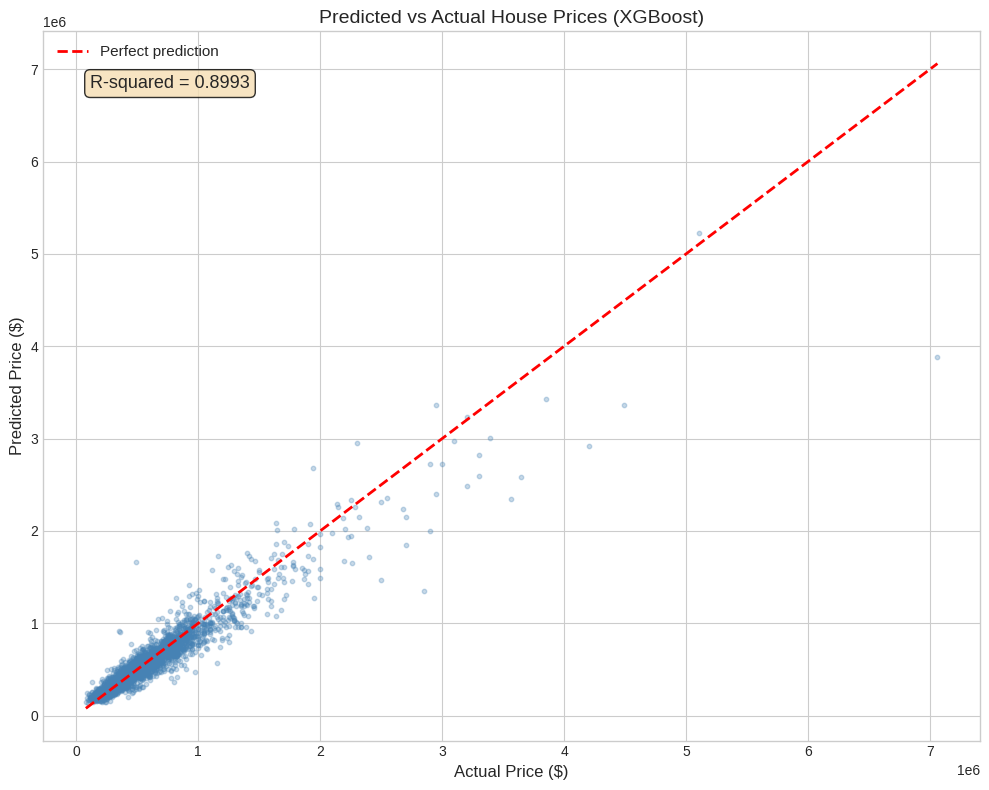

In [55]:
# Predicted vs Actual scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test, preds_test, alpha=0.3, s=10, color='steelblue')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Price ($)', fontsize=12)
ax.set_ylabel('Predicted Price ($)', fontsize=12)
ax.set_title('Predicted vs Actual House Prices (XGBoost)', fontsize=14)
ax.legend(fontsize=11)

r2_val = r2_score(y_test, preds_test)
ax.text(0.05, 0.92, f'R-squared = {r2_val:.4f}', transform=ax.transAxes,
        fontsize=13, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

## Task 3 — Feature Importance Analysis (William, VP Finance)

> "I'd like to know which property types are weighing most heavily in the house prices predicted by your model."

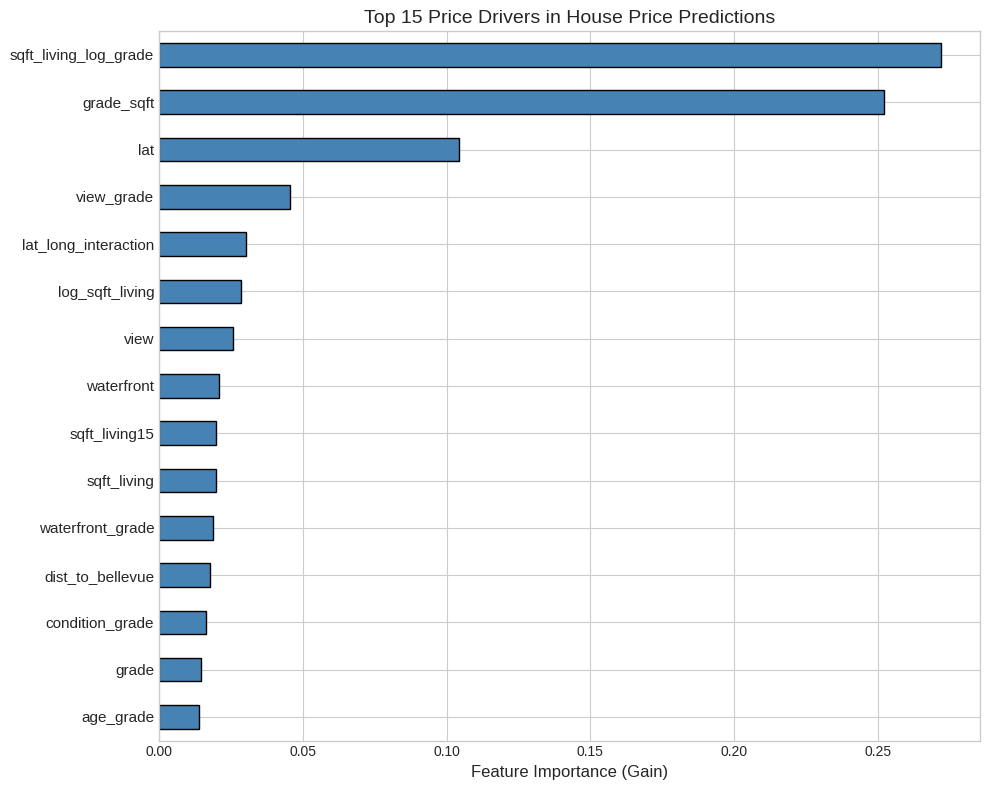


Top 7 Price Drivers (business interpretation):
  1. sqft_living_log_grade: importance = 0.2720
  2. grade_sqft: importance = 0.2523
  3. lat: importance = 0.1042
  4. view_grade: importance = 0.0455
  5. lat_long_interaction: importance = 0.0302
  6. log_sqft_living: importance = 0.0285
  7. view: importance = 0.0258


In [56]:
# Feature importance from XGBoost model
feature_names = list(X_train.columns)
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
top_n = 15
top_features = importances.nlargest(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
top_features.sort_values().plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
ax.set_title(f'Top {top_n} Price Drivers in House Price Predictions', fontsize=14)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()

print('\nTop 7 Price Drivers (business interpretation):')
for i, (feat, imp) in enumerate(importances.nlargest(7).items(), 1):
    print(f'  {i}. {feat}: importance = {imp:.4f}')

## Discussion Q3 — Insurance & Ethics (Task 6 — William, VP Finance)

> "Is there a way we can easily identify properties in low income areas and have the model lower those estimates to protect our insurance customers' interests?"

**The correct answer is Option 4: This would violate federal laws and/or ethics.**

### Analysis of all four options:

**Option 1: Lower predicted price for specific neighborhoods before training**
This manipulates training data to systematically undervalue properties in specific areas. This is data falsification that produces a model biased against certain neighborhoods — a direct proxy for race and income.

**Option 2: Add average income or demographic info as features**
Income and demographic data are strongly correlated with race in many US areas. Using these as features means the model learns to price differently based on neighborhood demographics — this is proxy discrimination, even without race as an explicit feature.

**Option 3: Post-prediction price reduction for specific zip codes**
Directly reducing values for certain zip codes is the textbook definition of **redlining** — systematically devaluing services to residents of specific areas based on demographics.

**Option 4: This would violate federal laws (CORRECT)**
All three proposals constitute forms of **redlining**, which violates:
- **Fair Housing Act (1968)**: Prohibits discrimination in housing-related transactions based on race, color, national origin, religion, sex, familial status, or disability
- **Equal Credit Opportunity Act**: Prohibits discrimination in credit transactions

Even though the stated intent is to "protect insurance customers," systematically lowering property valuations in low-income areas disproportionately harms protected classes and constitutes discriminatory pricing. The model should predict fair market value for **all** properties regardless of neighborhood demographics.

## Task 4 — External Factors Investigation (Devon, CEO)

> "Are there additional factors about these areas that might be affecting prices, which we aren't taking into account?"

### Research: Potential External Data Sources for King County

| Factor | Data Source | Merge Key | Expected Impact |
|--------|-------------|-----------|----------------|
| School quality ratings | GreatSchools.org | Zipcode | High — school districts strongly affect home prices |
| Crime rates | King County Sheriff / FBI UCR | Zipcode/City | Medium-High — safety is a major buying factor |
| Median household income | US Census / ACS | Zipcode | High — correlates with neighborhood desirability |
| Distance to transit | King County Metro | Lat/Long | Medium — commute access affects urban home values |
| Walk score | WalkScore.com API | Address/Lat/Long | Medium — walkability premium in urban areas |
| Employment centers proximity | BLS / County data | Lat/Long | Medium — proximity to jobs affects prices |

### What our current features already capture

Our dataset includes `lat`, `long`, and `zipcode`, which serve as **proxies** for many location-based external factors. The model can learn that certain coordinates/zipcodes have higher prices, effectively capturing schools, crime, income, and amenities through geographic position.

However, explicitly adding school ratings or crime data could help the model understand *why* certain locations are valuable, potentially improving predictions.

In [57]:
# Quantify location's impact: compare model with vs without location features
location_features = ['zipcode', 'lat', 'long']

# Model WITH location (same as our trained model)
preds_with = preds_test
r2_with = r2_score(y_test, preds_with)
rmse_with = np.sqrt(mean_squared_error(y_test, preds_with))

# Model WITHOUT location
non_loc_cols = [c for c in train_columns if c not in location_features
                and c not in ['dist_to_bellevue', 'lat_long_interaction']]
X_train_no_loc = X_train[non_loc_cols]
X_test_no_loc = X_test[non_loc_cols]
xgb_no_loc = XGBRegressor(**xgb_model.get_params())
xgb_no_loc.fit(X_train_no_loc, np.log1p(y_train))
preds_no = np.expm1(xgb_no_loc.predict(X_test_no_loc))
r2_without = r2_score(y_test, preds_no)
rmse_without = np.sqrt(mean_squared_error(y_test, preds_no))

print('Impact of location features (proxy for external factors):')
print(f'  WITH location:    R\u00b2 = {r2_with:.4f}, RMSE = ${rmse_with:,.0f}')
print(f'  WITHOUT location: R\u00b2 = {r2_without:.4f}, RMSE = ${rmse_without:,.0f}')
print(f'  R\u00b2 improvement:   {r2_with - r2_without:.4f}')
print(f'  RMSE reduction:   ${rmse_without - rmse_with:,.0f}')
print()
print('Location features (lat, long, zipcode) serve as proxies for external')
print('factors like school quality, crime rates, and neighborhood amenities.')

Impact of location features (proxy for external factors):
  WITH location:    R² = 0.8993, RMSE = $123,223
  WITHOUT location: R² = 0.7508, RMSE = $193,871
  R² improvement:   0.1485
  RMSE reduction:   $70,648

Location features (lat, long, zipcode) serve as proxies for external
factors like school quality, crime rates, and neighborhood amenities.


In [58]:
# Analyze price patterns by zipcode (shows external factor variation)
zip_stats = df.groupby('zipcode')['price'].agg(['mean', 'median', 'count', 'std']).round(0)
zip_stats = zip_stats.sort_values('median', ascending=False)

print('Top 10 most expensive zipcodes (median price):')
print(zip_stats.head(10).to_string())
print()
print('Bottom 10 least expensive zipcodes:')
print(zip_stats.tail(10).to_string())
print()
print(f'Price ratio (most vs least expensive zipcode median): '
      f'{zip_stats["median"].max() / zip_stats["median"].min():.1f}x')
print('This variation reflects external factors like schools, safety, and amenities.')

Top 10 most expensive zipcodes (median price):
              mean     median  count        std
zipcode                                        
98039    2166618.0  1892500.0     46  1175134.0
98004    1361288.0  1162500.0    288   756839.0
98040    1206933.0   997000.0    254   624253.0
98112    1095133.0   906000.0    249   594393.0
98006     871626.0   770000.0    462   453904.0
98005     802869.0   760000.0    151   260649.0
98075     793868.0   739999.0    337   292131.0
98119     847202.0   737500.0    168   446110.0
98109     878483.0   736000.0     99   454964.0
98102     905088.0   720000.0     99   807267.0

Bottom 10 least expensive zipcodes:
             mean    median  count       std
zipcode                                     
98022    312526.0  277500.0    213  119976.0
98148    285211.0  270000.0     49   94739.0
98023    287971.0  269000.0    465  110629.0
98003    296484.0  268000.0    256  111230.0
98198    302158.0  268000.0    259  148448.0
98188    286048.0  264000

## 5. Model Comparison

In [59]:
# Compare models side by side
comparison = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'preds'}
    for r in results.values()
]).set_index('model')

print(comparison.to_string())
print()
best_model_name = comparison['rmse'].idxmin()
print(f'Best model: {best_model_name} (lowest RMSE)')

                               rmse        r2
model                                        
XGBoost (log target)  123223.034089  0.899323
XGBoost (baseline)    127955.767211  0.891441

Best model: XGBoost (log target) (lowest RMSE)


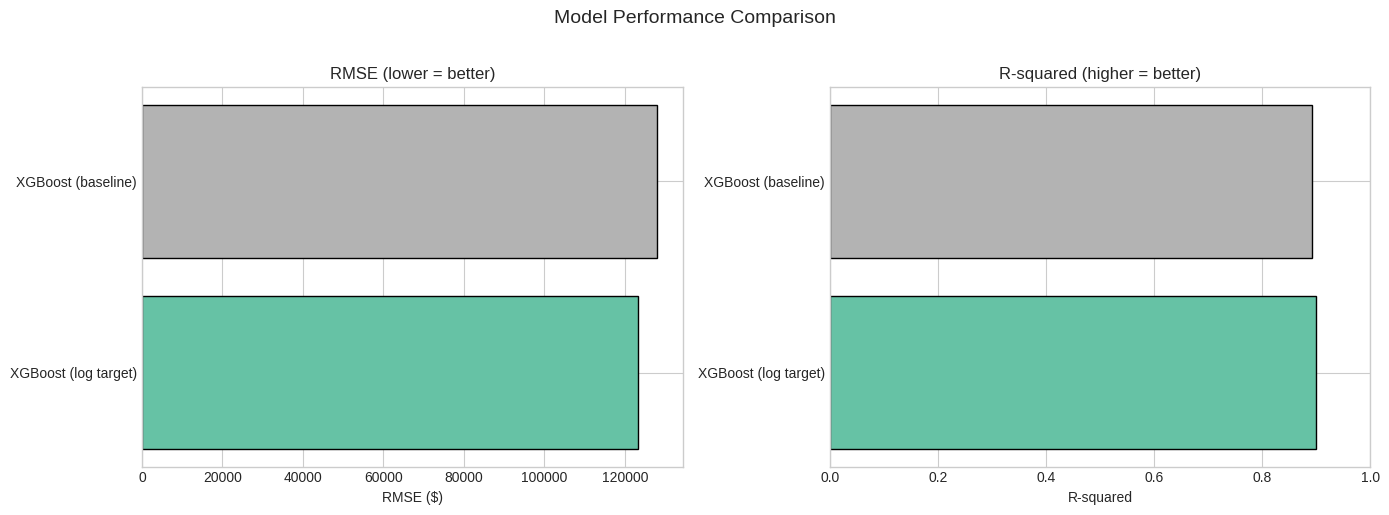

In [60]:
# Model comparison chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
models = comparison.index.tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

axes[0].barh(models, comparison['rmse'], color=colors, edgecolor='black')
axes[0].set_xlabel('RMSE ($)')
axes[0].set_title('RMSE (lower = better)')

axes[1].barh(models, comparison['r2'], color=colors, edgecolor='black')
axes[1].set_xlabel('R-squared')
axes[1].set_title('R-squared (higher = better)')
axes[1].set_xlim(0, 1)

plt.suptitle('Model Performance Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Presentational Visualizations

Publication-quality figures for the executive summary. Clean, professional, labeled.

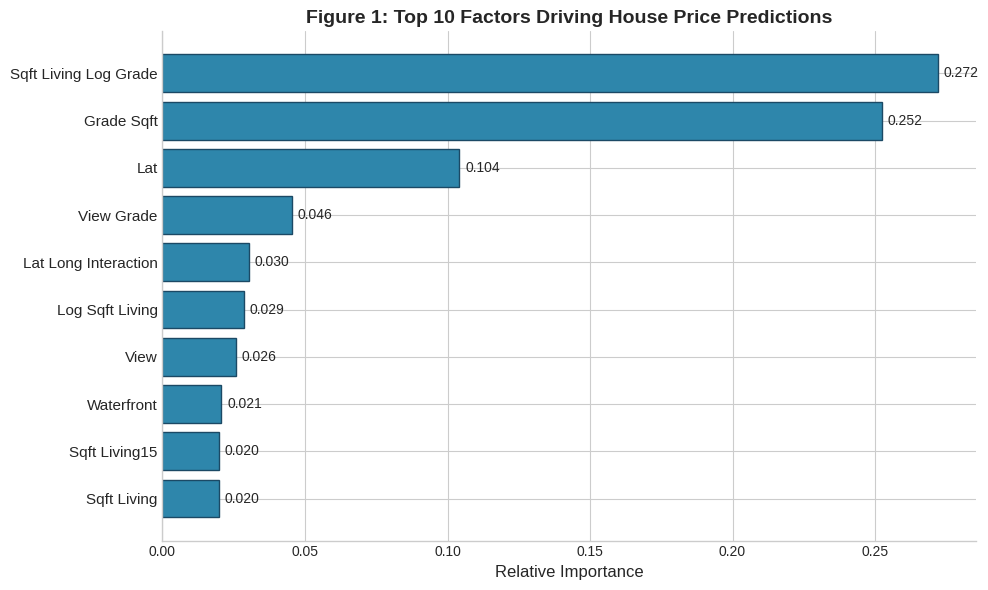

Saved: figure1_feature_importance.png


In [61]:
# FIGURE 1: Feature Importance (presentational quality — for William)
feature_names = list(X_train.columns)
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
top_10 = importances.nlargest(10).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(top_10)), top_10.values, color='#2E86AB', edgecolor='#1B4965')
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels([f.replace('_', ' ').title() for f in top_10.index], fontsize=11)
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Figure 1: Top 10 Factors Driving House Price Predictions',
             fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, val in zip(bars, top_10.values):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figure1_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figure1_feature_importance.png')

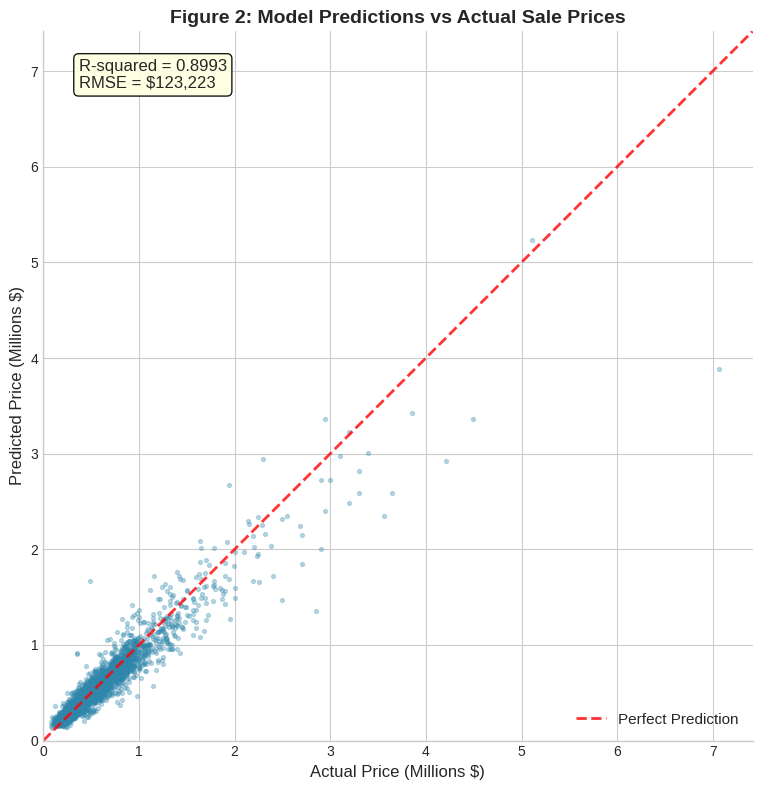

Saved: figure2_pred_vs_actual.png


In [62]:
# FIGURE 2: Predicted vs Actual (presentational quality — for Cecil)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test / 1e6, preds_test / 1e6, alpha=0.3, s=8, color='#2E86AB')
lims = [0, max(y_test.max(), preds_test.max()) / 1e6 * 1.05]
ax.plot(lims, lims, 'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
ax.set_xlabel('Actual Price (Millions $)', fontsize=12)
ax.set_ylabel('Predicted Price (Millions $)', fontsize=12)
ax.set_title('Figure 2: Model Predictions vs Actual Sale Prices',
             fontsize=14, fontweight='bold')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
ax.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r2_val = r2_score(y_test, preds_test)
rmse_val = np.sqrt(mean_squared_error(y_test, preds_test))
label = f"R-squared = {r2_val:.4f}\nRMSE = ${rmse_val:,.0f}"
ax.text(0.05, 0.92, label,
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('figure2_pred_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figure2_pred_vs_actual.png')

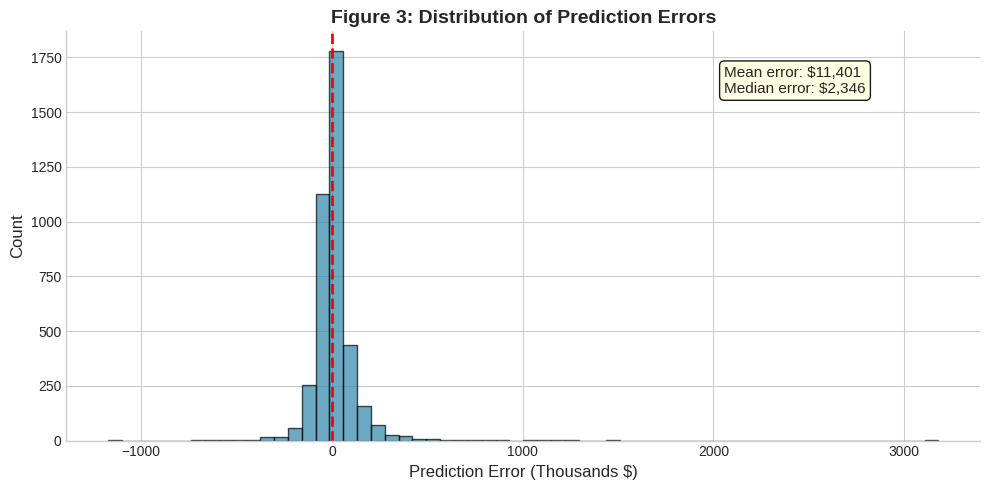

Saved: figure3_residuals.png


In [63]:
# FIGURE 3: Residual distribution
residuals = y_test - preds_test

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(residuals / 1000, bins=60, edgecolor='black', alpha=0.7, color='#2E86AB')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (Thousands $)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Figure 3: Distribution of Prediction Errors',
             fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.72, 0.85, f'Mean error: ${residuals.mean():,.0f}\nMedian error: ${residuals.median():,.0f}',
        transform=ax.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('figure3_residuals.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figure3_residuals.png')

## 7. Holdout Predictions (Task 2)

**CRITICAL**: Filename must be `team8-module3-predictions.csv` (DASHES, not underscores!)


In [64]:
# Preprocess holdout data using same feature engineering
holdout_X = preprocess(holdout, is_training=False, train_columns=train_columns)

print(f'Holdout features:  {holdout_X.shape}')
print(f'Training features: {X_train.shape}')
print(f'Columns match: {list(holdout_X.columns) == train_columns}')

Holdout features:  (1613, 39)
Training features: (16000, 39)
Columns match: True


In [65]:
# Generate predictions and save
holdout_preds = np.expm1(xgb_model.predict(holdout_X))

submission = pd.DataFrame({'price': holdout_preds})
submission.to_csv('team8-module3-predictions.csv', index=False)

# VERIFY
check = pd.read_csv('team8-module3-predictions.csv')
print('=== HOLDOUT VERIFICATION ===')
print('Filename:        team8-module3-predictions.csv')
print(f'Columns:         {list(check.columns)}')
print(f'Rows:            {len(check)}')
print(f'All same value?  {check["price"].nunique() == 1}  (should be False!)')
print(f'Min prediction:  ${check["price"].min():,.2f}')
print(f'Max prediction:  ${check["price"].max():,.2f}')
print(f'Mean prediction: ${check["price"].mean():,.2f}')
print()
print('First 10 predictions:')
print(check.head(10).to_string())

=== HOLDOUT VERIFICATION ===
Filename:        team8-module3-predictions.csv
Columns:         ['price']
Rows:            1613
All same value?  False  (should be False!)
Min prediction:  $127,841.40
Max prediction:  $3,975,482.00
Mean prediction: $534,653.58

First 10 predictions:
        price
0   370820.75
1   811765.44
2  1308844.10
3  2016259.50
4   681287.90
5   254433.89
6   783299.60
7   640727.06
8   420209.94
9   568454.90


## 8. Mini Holdout Check (PM Checkin — Due Feb 7)

Run on the mini holdout set and save for grading with the mini holdout grader notebook.

In [66]:
# Preprocess mini holdout and generate predictions
mini_X = preprocess(mini_holdout, is_training=False, train_columns=train_columns)
print(f'Mini holdout features: {mini_X.shape}')

mini_preds = np.expm1(xgb_model.predict(mini_X))

mini_sub = pd.DataFrame({'price': mini_preds})
mini_sub.to_csv('team8-module3-mini-predictions.csv', index=False)

check_mini = pd.read_csv('team8-module3-mini-predictions.csv')
print('Saved: team8-module3-mini-predictions.csv')
print(f'Rows: {len(check_mini)}')
print(f'Sample predictions: {check_mini["price"].head().tolist()}')

Mini holdout features: (81, 39)
Saved: team8-module3-mini-predictions.csv
Rows: 81
Sample predictions: [445928.22, 689932.3, 184195.84, 370087.3, 420209.94]


## Summary

| Component | Details |
|-----------|---------|
| **Model** | XGBoost with log-transformed target |
| **Key Technique** | Log transform on price to handle skewness (4.09) |
| **Hyperparameters** | 5,000 trees, max_depth=4, lr=0.02, subsample=0.8 |
| **Features** | Engineered interaction, ratio, and distance features |
| **Metrics** | RMSE, R-squared (computed above) |

### Files Generated
- `team8-module3-predictions.csv` — holdout predictions (1,613 homes) — **SUBMIT THIS**
- `team8-module3-mini-predictions.csv` — mini holdout for PM checkin (81 homes)
- `figure1_feature_importance.png` — top 10 price drivers
- `figure2_pred_vs_actual.png` — predicted vs actual scatter
- `figure3_residuals.png` — prediction error distribution